# Create Simulation



In [ ]:
# If you want to parallel computing, run this block
from IPython.parallel import Client

In [4]:

# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')
import datetime
from scipy import optimize

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from DataMaker_New import dataCleaner_new
from ESN import EchoState
from Loss_diag_updateV import loss
from GenerateSimulatedData import make_simulated_data

warnings.simplefilter('ignore')

# GARCH family
from arch import arch_model

# Torch nn
from torch import nn, optim
import torch

# Generate Option Data

Shape of true_vol_mean is (10, 201)
Shape of gen_vol_obs is (10, 201, 10)
Shape of us is (10, 201)
Shape of ps is (10, 201)
Shape of rs is (1, 201)
Shape of Ts is (10,)
Shape of Ks is (10, 201, 10)
Shape of ys is (10, 201, 10)
smallest strike price is 1713.85
[=======100%=======] After Truncation
Shape of true_vol_mean is (10, 194)
Shape of gen_vol_obs is (10, 10)
Shape of us_ccd is (10, 194, 8)
Shape of ps is (10, 194)
Shape of rs is (1, 194)
Shape of Ts is (10,)
Shape of Ks is (10, 194, 10)
Shape of ys is (10, 194, 10)
Attached 167 train days; 1670 train observations
Attached 2 valid days; 20 valid observations
Attached 25 test days; 250 test observations


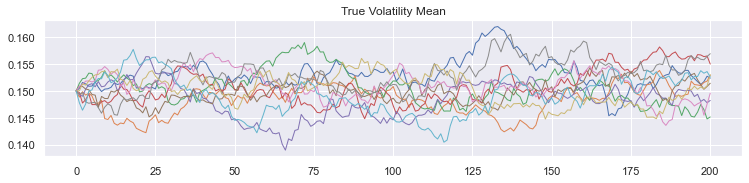

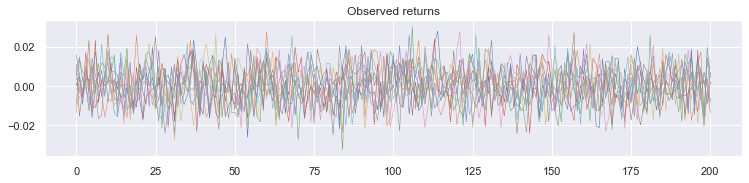

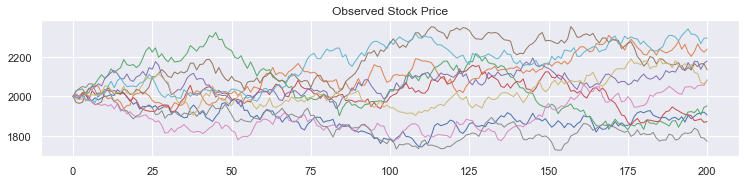

In [8]:
u_dim = 8
topK = 10
n_scenario = 10
true_vol_std = 0.01
np.random.seed(1234)
train_list, valid_list, test_list, true_vol = make_simulated_data(n_scenarios= n_scenario, n_steps=200 ,true_vol_std=0.01, topK=topK, 
                                                                  x0=0.15, #0.15 as default
                                                                  theta=10, #10 as default
                                                                  random_state=1234, init_price=2000, u_dim=u_dim)

train_dates = list(train_list[0].keys())
valid_dates = list(valid_list[0].keys())
test_dates = list(test_list[0].keys())
num_train_day = max(train_dates)-min(train_dates)+1
num_valid_day = max(valid_dates)-min(valid_dates)+1
num_test_day = max(test_dates)-min(test_dates)+1
num_train_obs = num_train_day*topK 
num_valid_obs = num_valid_day*topK
num_test_obs = num_test_day*topK 

print("Attached {} train days; {} train observations".format(num_train_day, num_train_obs))
print("Attached {} valid days; {} valid observations".format(num_valid_day, num_valid_obs))
print("Attached {} test days; {} test observations".format(num_test_day, num_test_obs))

## Prepare Functions

In [9]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(theta_now, dt, **fx_args):
    """
    :params theta_now theta_t
    
    **fx_args
    :params G reservoir transition matrix
    :params G_in input translation matrix
    :params b reservoir bias vector
    :params u_quad_now u_t^2
    """
    G = fx_args["G"]
    G_in = fx_args["G_in"]
    b = fx_args["b"]
    u_quad_now = fx_args["u_quad_now"]
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    return theta_next
    

def BSf(theta_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def getCoverage(mean, std, truth):
    check_points = np.arange(5, 100, 5) / 100
    
    
    samples = np.random.normal( mean, std, (50, 100) )
    
    coverage_for_1_observation = []
    for check_point in check_points:
        lower = np.quantile(samples, 0.5-check_point/2, axis=1 )
        upper = np.quantile(samples, 0.5+check_point/2, axis=1 ) 
        coverage_for_1_observation.append( float(np.count_nonzero( np.logical_and( lower < truth , truth < upper ) ) / 50 ) )
    return coverage_for_1_observation

# SLEEP!

In [ ]:
np.random.seed(1234)
gradient = grad(loss)


forward_k = 20

error_for_all_scenario = []
best_itr_for_all_scenario = []
best_train_itr_for_all_scenario = []
best_valid_itr_for_all_scenario= []
params_for_all_scenario = []
ms_s_for_all_scenario = []
Cs_s_for_all_scenario = []
pred_Cs_for_all_scenario = []

train_pred_ms_for_all_scenario = []
pred_ms_for_all_scenario = []


theta_dim = 64
print("theta_dim = {}".format(theta_dim))   

for scenario_idx in range(n_scenario):
    best_valid_error = 999
    best_valid_itr = 0
    
    train_data = train_list[scenario_idx]
    valid_data = valid_list[scenario_idx]
    test_data = test_list[scenario_idx]
    
    step = 0.01
    m_t_1 = [np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0])]
    v_t_1 = [np.array([0]), np.array([0]), np.array([0]), np.array([0]), np.array([0])]
    beta_1 = 0.9
    beta_2 = 0.999
    epsillon = 1e-8
    
    print("The {}th scenario".format(scenario_idx+1))
    alpha = 0.01
    connectivity = 0.4
    spectral_radius = 1.2
    bday_p_year = 252
    bias = -2.65

    v_scale = 4.0
    w = 0.0001

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    ESN.G_in *= 2
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    best_train_error = 100
    best_train_itr = 0
    
    #%%%%%% Error trajectories
    
    test_error_traj = []
    params_traj = []
    ms_s_traj = []
    Cs_s_traj = []
    
    train_pred_ms_traj = []
    pred_ms_traj = []
    pred_Cs_traj = []
    
    for em_itr in range(50):
        dt=1
        points = MerweScaledSigmaPoints(theta_dim, alpha=.001, beta=2., kappa=0)
        ukf = UnscentedKalmanFilter(dim_x=ESN.theta_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
        ukf.x = np.ones(ESN.theta_dim)* 0.006 # initial state
        ukf.P *= 0.01 # initial uncertainty
        ukf.R = np.diag([v]*topK) # 1 standard
        ukf.Q = np.eye(theta_dim)*w

        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(train_data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = train_data[day]["risk ir"] 
            u_t = train_data[day]["return"].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = train_data[day]["price"]

            ## Option wise data
            y_t = train_data[day]["option price"]
            K_t = train_data[day]["Strike"]
            T_t = train_data[day]["Exercise Time"]

            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother(ms, Cs, fx=ESNf, G=ESN.G, G_in=ESN.G_in, b=ESN.b, u_s=us)


        params = [copy.copy(ESN.G), copy.copy(ESN.G_in), copy.copy(ESN.b), copy.copy(w), copy.copy(v)]

        
        try:
            curr_loss = loss(params,
                             ms_s, Cs_s, cvs_s,
                             u_quad_s,
                             ps, rs, Ks, Ts, ys,
                             num_train_obs,
                             reg=alpha)
            curr_grad = gradient(params,
                                 ms_s, Cs_s, cvs_s,
                                 u_quad_s,
                                 ps, rs, Ks, Ts, ys,
                                 num_train_obs,
                                 reg=alpha)

######################## Adam Optimizer ###########################
            
            m_t = [None, None, None, None, None]
            v_t = [None, None, None, None, None]
            m_t_hat = [None, None, None, None, None]
            v_t_hat = [None, None, None, None, None]

            m_t[0] = beta_1 * m_t_1[0] + (1-beta_1) * curr_grad[0]
            v_t[0] = beta_2 * v_t_1[0] + (1-beta_2) * (curr_grad[0] * curr_grad[0])
            m_t_hat[0] = m_t[0] / (1-beta_1 ** (em_itr+1))
            v_t_hat[0] = v_t[0] / (1-beta_2 ** (em_itr+1))
            params[0] -= step * m_t_hat[0] / (np.sqrt(v_t_hat[0]) + epsillon)

            m_t[1] = beta_1 * m_t_1[1] + (1-beta_1) * curr_grad[1]
            v_t[1] = beta_2 * v_t_1[1] + (1-beta_2) * (curr_grad[1] * curr_grad[1])
            m_t_hat[1] = m_t[1] / (1-beta_1 ** (em_itr+1))
            v_t_hat[1] = v_t[1] / (1-beta_2 ** (em_itr+1))
            params[1] -= step * m_t_hat[1] / (np.sqrt(v_t_hat[1]) + epsillon)

            m_t[2] = beta_1 * m_t_1[2] + (1-beta_1) * curr_grad[2]
            v_t[2] = beta_2 * v_t_1[2] + (1-beta_2) * (curr_grad[2] * curr_grad[2])
            m_t_hat[2] = m_t[2] / (1-beta_1 ** (em_itr+1))
            v_t_hat[2] = v_t[2] / (1-beta_2 ** (em_itr+1))
            params[2] -= step * m_t_hat[2] / (np.sqrt(v_t_hat[2]) + epsillon)
            
            m_t[3] = beta_1 * m_t_1[3] + (1-beta_1) * curr_grad[3]
            v_t[3] = beta_2 * v_t_1[3] + (1-beta_2) * (curr_grad[3] * curr_grad[3])
            m_t_hat[3] = m_t[3] / (1-beta_1 ** (em_itr+1))
            v_t_hat[3] = v_t[3] / (1-beta_2 ** (em_itr+1))
            params[3] -= step * m_t_hat[3] / (np.sqrt(v_t_hat[3]) + epsillon)

            m_t[4] = beta_1 * m_t_1[4] + (1-beta_1) * curr_grad[4]
            v_t[4] = beta_2 * v_t_1[4] + (1-beta_2) * (curr_grad[4] * curr_grad[4])
            m_t_hat[4] = m_t[4] / (1-beta_1 ** (em_itr+1))
            v_t_hat[4] = v_t[4] / (1-beta_2 ** (em_itr+1))
            params[4] -= step * m_t_hat[4] / (np.sqrt(v_t_hat[4]) + epsillon)

            m_t = m_t_1
            v_t = v_t_1

###################################################################

        except RuntimeWarning or LinAlgError or OverflowError or w <= 0:
            print("set w to 1e-6 ensure positive")
            pass

        ESN.G, ESN.G_in, ESN.b, _, __ = params
        w = max(0.000001, params[3][0]) # Change form arraybox back to scalar
        v = max(0.000001, params[4][0]) # Change form arraybox back to scalar

        
################################################################### Training Performance
        
        train_pred_ms = []
        train_errors = []
        np.delete(ms_s,0,0)
        np.delete(Cs_s,0,0)
        for i in range(0, len(ms_s)-1):

            ukf.predict(fx = ESNf,  G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=u_quad_s[i])
            train_pred_ms.append(np.average(ukf.x_prior))
            pred_price = BSf(ukf.x_prior, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
            error = np.average(np.abs(ys[i]-pred_price) /ys[i])
            train_errors.append(error)
            ukf.update(ys[i], hx=BSf, p_t=ps[i], r_t=rs[i], K_t=Ks[i], T_t=Ts[i])
        
        train_pred_ms_traj.append(train_pred_ms)
        avg_train_error = np.average(train_errors)
################################################################### Validation Performance
        ukf.x = ms_s[-1]
        ukf.P = Cs_s[-1]
        valid_errors = []
        pred_ms = []
        pred_Cs = []
        
        all_valid_days = sorted(list(valid_data.keys()))
        for day in all_valid_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = valid_data[day]["risk ir"]
            u_t = valid_data[day]["return"].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = valid_data[day]["price"]

            ## Option wise data
            y_t = valid_data[day]["option price"]
            K_t = valid_data[day]["Strike"]
            T_t = valid_data[day]["Exercise Time"]
            
            ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
            pred_ms.append(ukf.x_prior)
            pred_Cs.append(ukf.P_prior)
            pred_price = BSf(ukf.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            error = np.average(np.abs(y_t-pred_price) /y_t)
            valid_errors.append(error)
            
            ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
        avg_valid_error = np.average(valid_errors) 

################################################################### Testing Performance
        
        # forward K step prediction
        k_step_test_error = []

        test_k_step_pred_ms = {}
        test_k_step_pred_Cs = {}
        
        for k in range(1, min(forward_k+1, num_test_day+1)): 
            
            test_k_step_pred_ms[k] = []
            test_k_step_pred_Cs[k] = []
            
            test_errors = []            
            all_test_days = sorted(list(test_data.keys()))
            
            for idx in range(len(all_test_days) - k):
                
                ukf_pred = copy.deepcopy(ukf)
                
                # For loop for k predictions forward
                for shift in range(k) :
                    # get observable data
                    ## Stock Wise and market wise data
                    r_t = test_data[all_test_days[idx+shift]]["risk ir"]
                    u_t = test_data[all_test_days[idx+shift]]["return"].reshape([-1]) * math.sqrt(bday_p_year)
                    p_t = test_data[all_test_days[idx+shift]]["price"]

                    ## Option wise data
                    y_t = test_data[all_test_days[idx+shift]]["option price"]
                    K_t = test_data[all_test_days[idx+shift]]["Strike"]
                    T_t = test_data[all_test_days[idx+shift]]["Exercise Time"]

                    ukf_pred.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                    
                
                test_k_step_pred_ms[k].append(ukf_pred.x_prior)
                test_k_step_pred_Cs[k].append(ukf_pred.P_prior)
                
                
                pred_price = BSf(ukf_pred.x_prior, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
                error = np.average(np.abs(y_t-pred_price) /y_t)
                test_errors.append(error)
                
                
                # shift base one step forward
                r_t = test_data[all_test_days[idx]]["risk ir"] 
                u_t = test_data[all_test_days[idx]]["return"].reshape([-1]) * math.sqrt(bday_p_year)
                p_t = test_data[all_test_days[idx]]["price"]

                ## Option wise data
                y_t = test_data[all_test_days[idx]]["option price"]
                K_t = test_data[all_test_days[idx]]["Strike"]
                T_t = test_data[all_test_days[idx]]["Exercise Time"]

                ukf.predict(fx = ESNf, G=ESN.G, G_in=ESN.G_in, b= ESN.b, u_quad_now=np.power(u_t,2))
                ukf.update(y_t, hx=BSf, p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            
            if test_errors != []:
                avg_test_error = np.average(test_errors)
                k_step_test_error.append(avg_test_error)
            else:
                pass
            
            
################################################################### Show details
        print("EM Iter {} | Loss {:.4f} | Train Error {:.4f} | Val Error {:.4f} | Test 1-Error {:.4f} | Test max-Error {:.4f} |"  
              " Dyn var {:.2f} | Obs var {:.2f}".format(em_itr, curr_loss,
                                                        avg_train_error, avg_valid_error, k_step_test_error[0], k_step_test_error[-1],
                                                        w, v))
        
        # Get best validation itr
        if best_valid_error > avg_valid_error:
            best_valid_error = avg_valid_error
            best_valid_itr = em_itr
            if curr_loss > 5000:
                best_valid_itr -= 1
        
        if avg_valid_error - best_valid_error > 0.01 and best_valid_error < 0.03:
            break
        
        if last_avg_error < avg_valid_error and em_itr-best_itr >= 10:
            pass 
        elif last_avg_error < avg_valid_error and em_itr-best_itr < 10:
            pass
        elif last_avg_error > avg_valid_error and em_itr-best_itr < 10:
            last_avg_error = avg_valid_error
            model_performance = avg_test_error
            best_itr = em_itr
            
        if best_train_error > avg_train_error and em_itr-best_train_itr < 10:
            best_train_error = avg_train_error
            best_train_itr = em_itr
        elif best_train_error < avg_train_error:
            step = 0.002
    
        test_error_traj.append(k_step_test_error)
        params_traj.append(copy.deepcopy(params))
        ms_s_traj.append(ms_s)
        Cs_s_traj.append(Cs_s)
        pred_ms_traj.append(test_k_step_pred_ms)
        pred_Cs_traj.append(test_k_step_pred_Cs)
    
    error_for_all_scenario.append(test_error_traj)
    best_itr_for_all_scenario.append(best_itr)
    best_train_itr_for_all_scenario.append(best_train_itr)
    best_valid_itr_for_all_scenario.append(best_valid_itr)
    params_for_all_scenario.append(params_traj)
    ms_s_for_all_scenario.append(ms_s_traj)
    Cs_s_for_all_scenario.append(Cs_s_traj)
    pred_ms_for_all_scenario.append(pred_ms_traj)
    pred_Cs_for_all_scenario.append(pred_Cs_traj)
    train_pred_ms_for_all_scenario.append(train_pred_ms_traj)
    
    print("best val error: {} at {}th iteration, Model Performance: {} | theta_dim = {}".format(last_avg_error,
                                                                                                best_itr,
                                                                                                model_performance,
                                                                                                theta_dim))
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

theta_dim = 64
The 1th scenario
EM Iter 0 | Loss 20262.1736 | Train Error 0.1002 | Val Error 0.0859 | Test 1-Error 0.1024 | Test max-Error 0.1015 | Dyn var 0.01 | Obs var 4.01
EM Iter 1 | Loss -253.0178 | Train Error 0.0844 | Val Error 0.0705 | Test 1-Error 0.0864 | Test max-Error 0.0889 | Dyn var 0.00 | Obs var 4.02
EM Iter 2 | Loss 279.4872 | Train Error 0.0731 | Val Error 0.0593 | Test 1-Error 0.0752 | Test max-Error 0.0757 | Dyn var 0.01 | Obs var 4.02
EM Iter 3 | Loss -258.0728 | Train Error 0.0561 | Val Error 0.0424 | Test 1-Error 0.0579 | Test max-Error 0.0627 | Dyn var 0.00 | Obs var 4.03
EM Iter 4 | Loss 98.7026 | Train Error 0.0447 | Val Error 0.0311 | Test 1-Error 0.0462 | Test max-Error 0.0487 | Dyn var 0.01 | Obs var 4.04
EM Iter 5 | Loss -272.5563 | Train Error 0.0304 | Val Error 0.0174 | Test 1-Error 0.0310 | Test max-Error 0.0345 | Dyn var 0.00 | Obs var 4.04
EM Iter 6 | Loss 18.4576 | Train Error 0.0228 | Val Error 0.0205 | Test 1-Error 0.0221 | Test max-Error 0.0227 |

# PLOT RESULT

error at k= 1 is 0.0262
error at k= 5 is 0.0313
error at k=10 is 0.0312
error at k=15 is 0.0320
error at k=20 is 0.0319


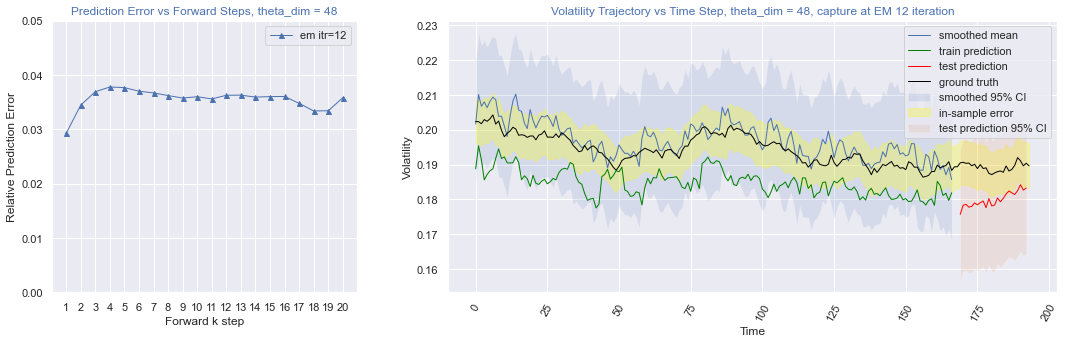

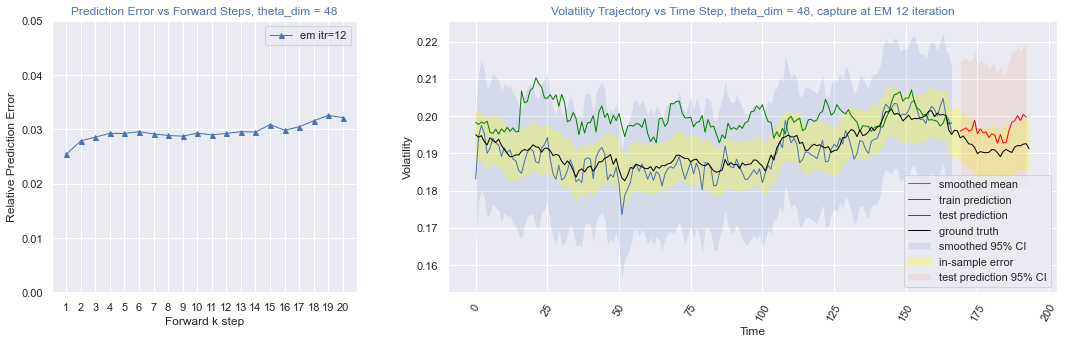

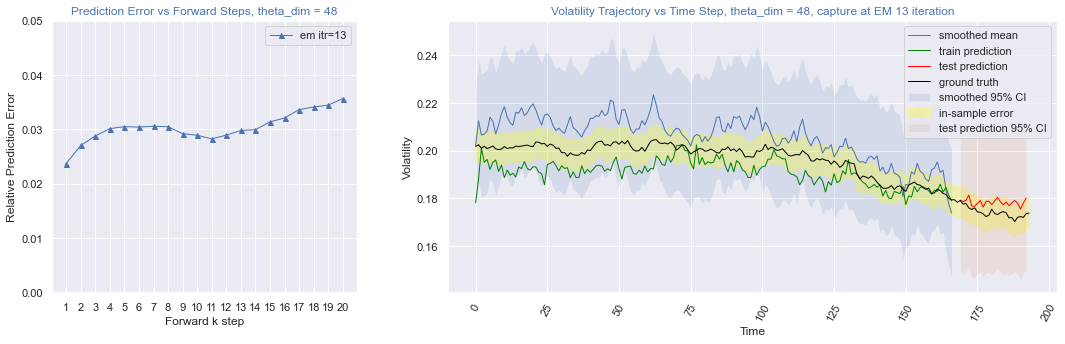

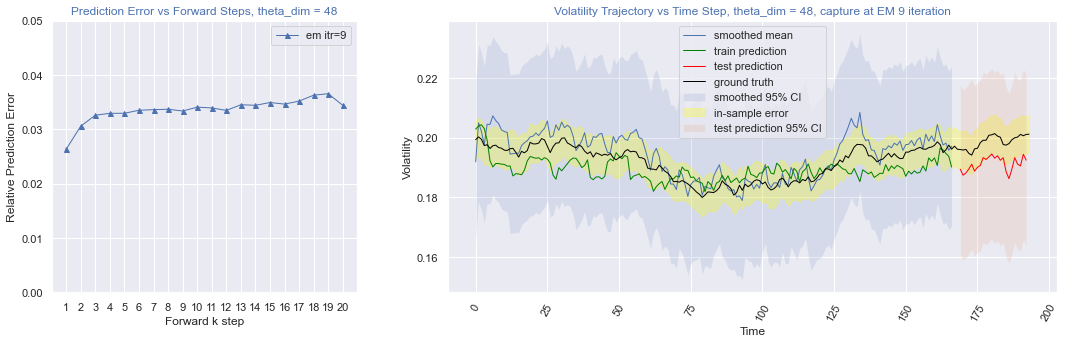

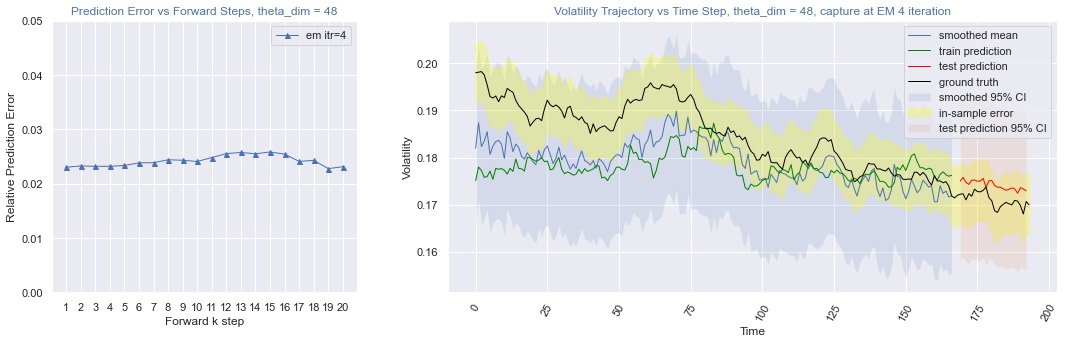

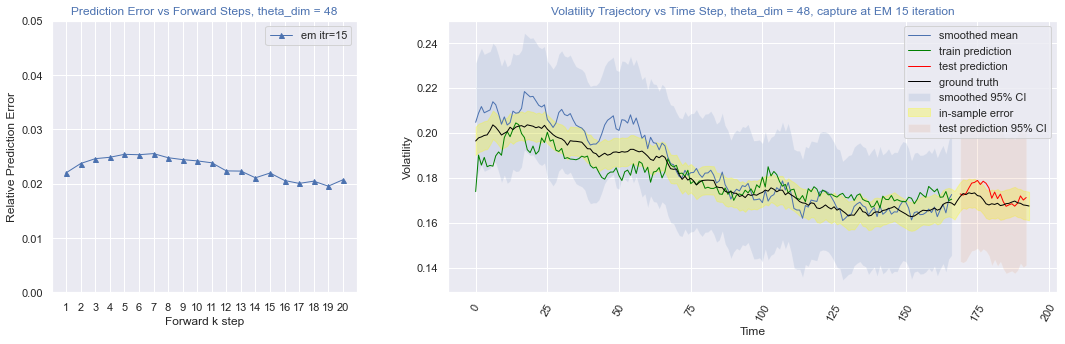

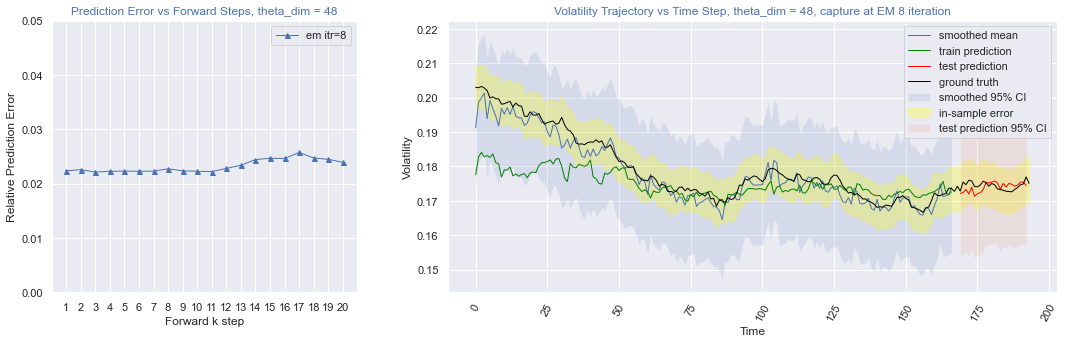

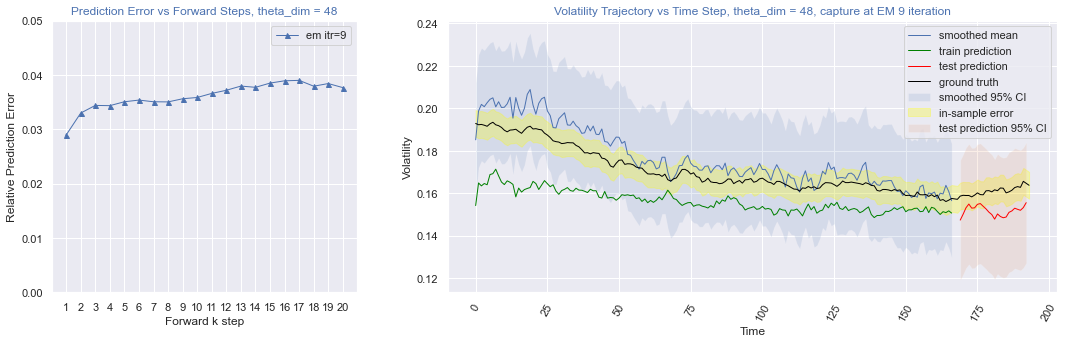

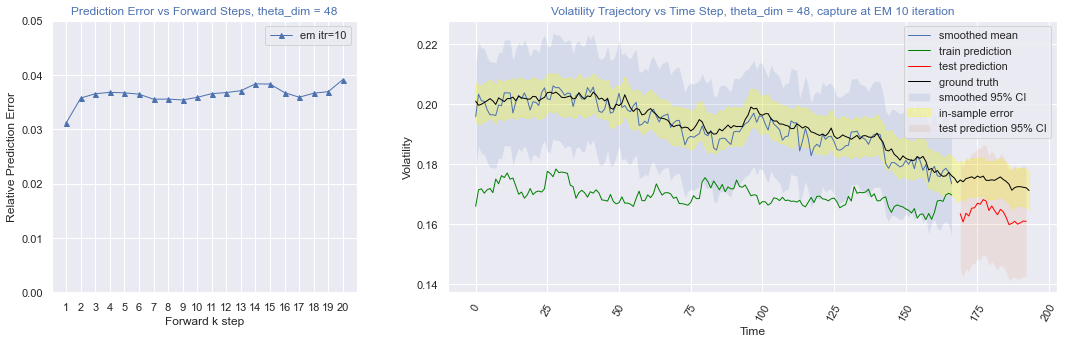

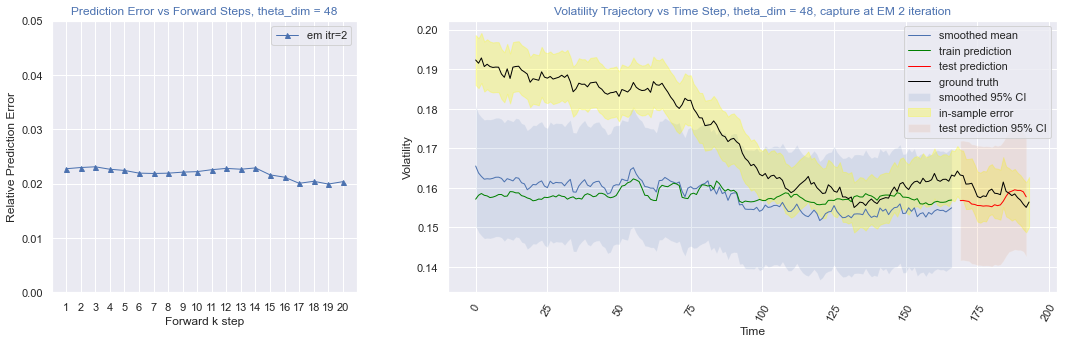

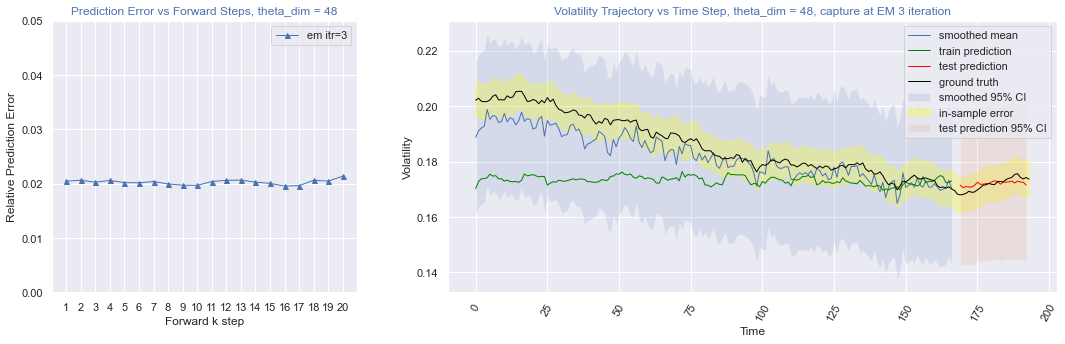

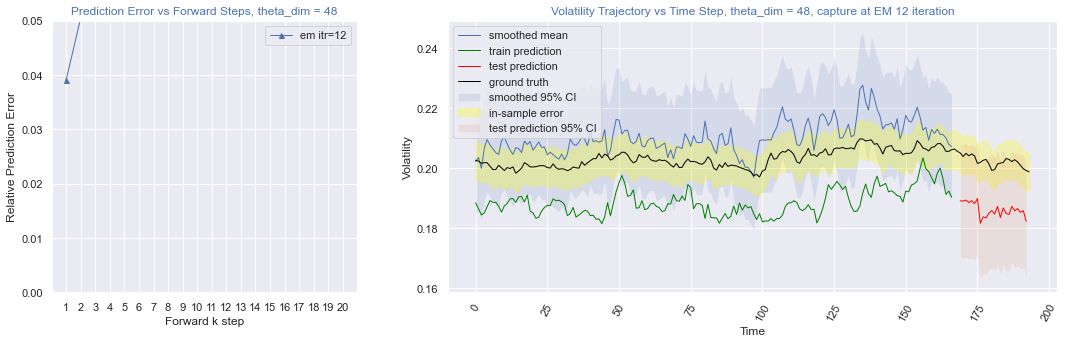

In [17]:
if len(error_for_all_scenario) == 0:
    error_for_all_scenario.append(test_error_traj)
    best_itr_for_all_scenario.append(best_itr)
    best_train_itr_for_all_scenario.append(best_train_itr)
    params_for_all_scenario.append(params_traj)
    ms_s_for_all_scenario.append(ms_s_traj)
    Cs_s_for_all_scenario.append(Cs_s_traj)
    pred_ms_for_all_scenario.append(pred_ms_traj)
    train_pred_ms_for_all_scenario.append(train_pred_ms_traj)
    print("just appended once")
    
warnings.simplefilter('error')

error_averager = []
all_pred_days = sorted(list(valid_data.keys()) + list(test_data.keys()))
for k in range(len(ms_s_for_all_scenario)):

    
    mean_iteration = best_valid_itr_for_all_scenario[k]
    iterations = range(mean_iteration, mean_iteration+1) 
    
    sns.set()
    fig = plt.figure(figsize=(18, 5))
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[1, 2], height_ratios=[1])
    title = "Stationary_THETA_DIM={}_SCENARIO={}_ALPHA={}_ITR={}".format(theta_dim, k+1, alpha, mean_iteration)
#     fig.suptitle(title)
    

    # forward steps
    a = fig.add_subplot(spec[0, 0])
    xlabel = list(range(1, forward_k+1))
    plt.xticks(xlabel)
    a.set_ylim(0.0, 0.05)
    a.set_title('Prediction Error vs Forward Steps, theta_dim = {}'.format(theta_dim), color='C0')
    for i in iterations:
        show = error_for_all_scenario[k][i]
        if i > 0 and i < 49:
            error_averager.append(show)
        a.plot([i+1 for i in range(forward_k)], show, marker='^', markersize= 5, linewidth=1)
    plt.xlabel("Forward k step")
    plt.ylabel("Relative Prediction Error")
    a.legend(["em itr={}".format(i) for i in iterations])
    
    
    # volatility trajectory
    b = fig.add_subplot(spec[0, 1])
    averager = np.ones(theta_dim) / (theta_dim)
    b.set_title('Volatility Trajectory vs Time Step, theta_dim = {}, capture at EM {} iteration'.format(theta_dim, mean_iteration), color='C0')
    legend = []
    opaque = 0.9/(len(iterations)+1)
    for i in iterations:
        smoothed_volatility_mean = np.average(ms_s_for_all_scenario[k][i], axis=1) #i+1
        smoothed_volatility_std = np.array( [math.sqrt(np.matmul(np.matmul(averager.T, _), averager.T)) for _ in Cs_s_for_all_scenario[k][i]]) #i+1
        smoothed_volatility_ci_upper = smoothed_volatility_mean + 2*smoothed_volatility_std
        smoothed_volatility_ci_lower = smoothed_volatility_mean - 2*smoothed_volatility_std

        predicted_volatility_mean = np.average(pred_ms_for_all_scenario[k][i][1], axis=1)
        predicted_volatility_std = np.array( [math.sqrt(np.matmul(np.matmul(averager.T, _), averager.T)) for _ in pred_Cs_for_all_scenario[k][i][1] ])
        predicted_volatility_ci_upper = predicted_volatility_mean + 2*predicted_volatility_std
        predicted_volatility_ci_lower = predicted_volatility_mean - 2*predicted_volatility_std
        

        train_predicted_volatility_mean = train_pred_ms_for_all_scenario[k][i]        
        
        b.plot(all_days, smoothed_volatility_mean[1:], linewidth=1, label="smoothed mean".format(i), )
        b.plot(all_days, train_predicted_volatility_mean, linewidth=1, color = "green", label="train prediction".format(i),)
        b.plot(list(test_data.keys())[:-1], predicted_volatility_mean, linewidth=1, color = "red", label="test prediction".format(i))
        b.plot(range(len(true_vol[k])) , true_vol[k], linewidth=1, color = "black", label="ground truth" )
        
        b.fill_between(all_days, smoothed_volatility_ci_upper[1:], smoothed_volatility_ci_lower[1:], alpha = 0.3*opaque*(1+i-mean_iteration), label="smoothed 95% CI")
        b.fill_between(range(len(true_vol[k])), true_vol[k]+2*true_vol_std/math.sqrt(topK), 
                       true_vol[k]-2*true_vol_std/math.sqrt(topK), 
                       alpha = 0.6*opaque*(1+i-mean_iteration), label="in-sample error", color = "yellow")
        b.fill_between(list(test_data.keys())[:-1], predicted_volatility_ci_upper, predicted_volatility_ci_lower, alpha = 0.3*opaque*(1+i-mean_iteration), label="test prediction 95% CI")
    plt.xlabel("Time")
    plt.ylabel("Volatility")
    b.legend()
    plt.xticks(rotation=60)
#     plt.show()
    
    plt.savefig("./output_fig/coverage/{}.jpg".format(title))
error_averager = np.mean(np.array(error_averager), axis=0)

print("error at k= 1 is {:.4f}".format(error_averager[0]))
print("error at k= 5 is {:.4f}".format(error_averager[4]))
print("error at k=10 is {:.4f}".format(error_averager[9]))
print("error at k=15 is {:.4f}".format(error_averager[14]))
print("error at k=20 is {:.4f}".format(error_averager[19]))

# VERIFY COVERAGE

In [9]:
def getCoverage(mean, std, truth):
    check_points = np.arange(5, 100, 5) / 100
    
    nums = 200
    
    samples = np.random.normal( mean, std, (nums, 100) )
    
    coverage_for_1_observation = []
    for check_point in check_points:
        lower = np.quantile(samples, 0.5-check_point/2, axis=1 )
        upper = np.quantile(samples, 0.5+check_point/2, axis=1 ) 
        coverage_for_1_observation.append( float(np.count_nonzero( np.logical_and( lower < truth , truth < upper ) ) / nums ) )
    return coverage_for_1_observation

In [10]:
test_start_idx = min(test_data.keys())
test_end_idx = max(test_data.keys())

averager = np.ones(theta_dim) / (theta_dim)

cov_for_all_k = []
for k in range(1, forward_k+1):
    cov_for_one_k = []
    
    for scenario_idx in range(0,n_scenario):
        if best_valid_itr_for_all_scenario[scenario_idx] > 0 and best_valid_itr_for_all_scenario[scenario_idx] < 49:
       
            target_itr = best_valid_itr_for_all_scenario[scenario_idx]
            test_prediction_results_ms = pred_ms_for_all_scenario[scenario_idx][target_itr][k]
            test_prediction_results_Cs = pred_Cs_for_all_scenario[scenario_idx][target_itr][k]

            cov_for_one_scenario = []
            for coverage_obs_idx in range(len(test_prediction_results_ms)):
                idx_in_test_data = coverage_obs_idx+test_start_idx+k-1
                ground_truth = test_list[scenario_idx][idx_in_test_data]['true vol']

                this_m = test_prediction_results_ms[coverage_obs_idx]
                this_C = test_prediction_results_Cs[coverage_obs_idx]

                coverage_predicted_mean = np.mean(this_m)
                coverage_predicted_std = math.sqrt(np.matmul(np.matmul(averager.T, this_C), averager.T))
                cov_for_one_scenario.append( getCoverage(coverage_predicted_mean, coverage_predicted_std, ground_truth) )
            cov_for_one_scenario = np.mean(np.array(cov_for_one_scenario), axis=0)

            cov_for_one_k.append(cov_for_one_scenario)
    cov_for_one_k = np.mean(np.array(cov_for_one_k), axis=0)
    cov_for_all_k.append(cov_for_one_k)

95% coverage for  1 step is 0.9757
95% coverage for  5 step is 0.9045
95% coverage for 10 step is 0.9071
95% coverage for 15 step is 0.9050
95% coverage for 20 step is 0.9122


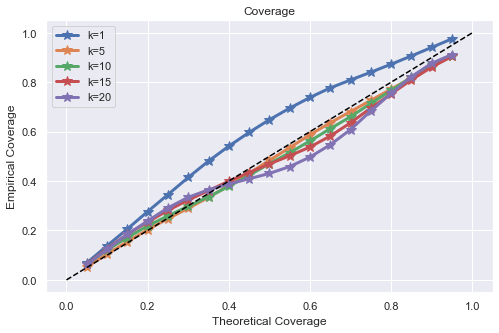

In [50]:
import matplotlib.lines as lines

check_points = np.arange(5, 100, 5) / 100
care = [0, 4, 9, 14, 19]

fig = plt.figure(figsize=(8,5))
plt.title("Coverage")
for i in care:
    print("95% coverage for {:2} step is {:.4f}".format(i+1 , cov_for_all_k[i][-1]))
    plt.plot( check_points, cov_for_all_k[i] , marker="*", markersize=10,label="k={}".format(i+1), linewidth = 3)
plt.plot( [0,1], [0,1] , linestyle="--", color="black")
plt.legend()
plt.xlabel("Theoretical Coverage")
plt.ylabel("Empirical Coverage")
plt.savefig("./output_fig/coverage/Stationary_theta{}_alpha1e-2_step1e-2.jpg".format(theta_dim))


## save pre-trained data

In [14]:
# import gzip, pickle, pickletools
# file_path = './Pretrained_data/Stationary_THETA{}.pkl'.format(theta_dim)

# with gzip.open(file_path, "wb") as f:
#     ALL_DATA = {
#         "error_for_all_scenario":error_for_all_scenario,
#         "best_itr_for_all_scenario":best_itr_for_all_scenario,
#         "best_train_itr_for_all_scenario":best_train_itr_for_all_scenario,
#         "best_valid_itr_for_all_scenario":best_valid_itr_for_all_scenario,
#         "params_for_all_scenario":params_for_all_scenario,
#         "ms_s_for_all_scenario":ms_s_for_all_scenario,
#         "Cs_s_for_all_scenario":Cs_s_for_all_scenario,
#         "pred_ms_for_all_scenario":pred_ms_for_all_scenario,
#         "pred_Cs_for_all_scenario":pred_Cs_for_all_scenario,
#         "train_pred_ms_for_all_scenario":train_pred_ms_for_all_scenario,
#         "cov_for_all_k":cov_for_all_k,
#         "num_train_day":num_train_day,
#         "num_valid_day":num_valid_day,
#         "num_test_day":num_test_day,
#         "num_train_obs":num_train_obs,
#         "num_valid_obs":num_valid_obs,
#         "num_test_obs":num_test_obs,
#         "train_list":train_list,
#         "valid_list":valid_list,
#         "test_list":test_list,
#         "true_vol":true_vol,
#         "alpha":alpha,
#         "theta_dim":theta_dim,
#     }
#     pickled = pickle.dumps(ALL_DATA)
#     optimized_pickle = pickletools.optimize(pickled)
#     f.write(optimized_pickle)

# del ALL_DATA

# For HARCH and GARCH family

Shape of true_vol_mean is (100, 201)
Shape of gen_vol_obs is (100, 201, 10)
Shape of us is (100, 201)
Shape of ps is (100, 201)
Shape of rs is (1, 201)
Shape of Ts is (10,)
Shape of Ks is (100, 201, 10)
Shape of ys is (100, 201, 10)
smallest strike price is 1299.09
[=======100%=======] After Truncation
Shape of true_vol_mean is (100, 194)
Shape of gen_vol_obs is (100, 10)
Shape of us_ccd is (100, 194, 8)
Shape of ps is (100, 194)
Shape of rs is (1, 194)
Shape of Ts is (10,)
Shape of Ks is (100, 194, 10)
Shape of ys is (100, 194, 10)
Attached 167 train days; 1670 train observations
Attached 2 valid days; 20 valid observations
Attached 25 test days; 250 test observations


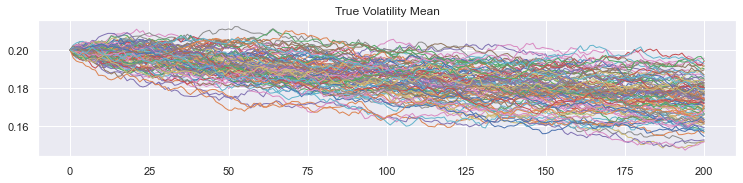

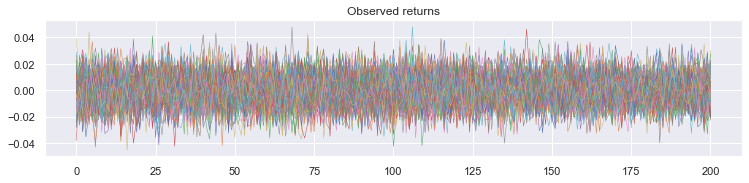

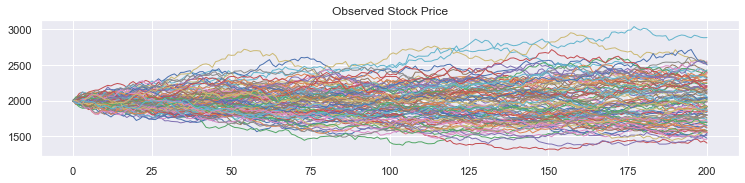

In [33]:
u_dim = 8
topK = 10
n_scenario = 100
np.random.seed(1234)
train_list, valid_list, test_list, true_vol = make_simulated_data(n_scenarios= n_scenario, n_steps=200 ,true_vol_std=0.01, topK=topK, 
                                                                  x0=0.15, #0.15 as default, used for stationary; 0.2 for nonstationary
                                                                  theta=10, #10 as default, used for stationary; 1 for nonstationary
                                                                  random_state=1234, init_price=2000, u_dim=u_dim)
train_dates = list(train_list[0].keys())
valid_dates = list(valid_list[0].keys())
test_dates = list(test_list[0].keys())
num_train_day = max(train_dates)-min(train_dates)+1
num_valid_day = max(valid_dates)-min(valid_dates)+1
num_test_day = max(test_dates)-min(test_dates)+1
num_train_obs = num_train_day*topK 
num_valid_obs = num_valid_day*topK
num_test_obs = num_test_day*topK 

print("Attached {} train days; {} train observations".format(num_train_day, num_train_obs))
print("Attached {} valid days; {} valid observations".format(num_valid_day, num_valid_obs))
print("Attached {} test days; {} test observations".format(num_test_day, num_test_obs))

In [34]:
def cvtLisQuantile(simulation):
    forward_k = len(simulation[0])
    check_points = np.arange(5, 100, 5) / 100
    lower = 0.5 - check_points/2
    upper = 0.5 + check_points/2
    array = np.swapaxes(simulation, 0, 1)
    quantiles_low = np.quantile(np.sqrt(array), lower, 1)
    quantiles_high = np.quantile(np.sqrt(array), upper, 1)
    result = {}
    for k in range(1, forward_k+1):
        result[k] = (quantiles_low[:, k-1], quantiles_high[:, k-1])
    return result

In [35]:
warnings.simplefilter("ignore")
from IPython.utils import io

forward_k = 20
calibration = 0.0

ar = 10
ma = 12
bday_p_year = 252

coverage_garch_all_scenarios = None
test_error_garch_all_scenario = None

for scenario_idx in range(n_scenario):
    train_data = train_list[scenario_idx]
    valid_data = valid_list[scenario_idx]
    test_data = test_list[scenario_idx]
    
    returns = []
    index = []
    for day in list(train_data.keys()):
        returns.append(train_data[day]["return"][0])
        index.append(day)
    for day in list(valid_data.keys()):
        returns.append(valid_data[day]["return"][0])
        index.append(day)
    last_val_date = list(valid_data.keys())[-1]
    last_val_date_idx = len(index)-1

    for day in list(test_data.keys()):
        returns.append(test_data[day]["return"][0])
        index.append(day)
    last_test_date = list(test_data.keys())[-1]

    start = 0
    end = last_test_date
    returns = np.array(returns) * math.sqrt(bday_p_year)
    
    with io.capture_output() as captured:
        am = arch_model(returns, vol='Garch', p=ar, o=0, q=ma, dist='Normal')
        res = am.fit(last_obs=last_val_date)
        forecasts = res.forecast(horizon=forward_k+1, start=last_val_date_idx-1, method="simulation", simulations=100)

    length_pred = forecasts.variance.count()[0]
    simulation_var = np.array(forecasts.simulations.variances[-length_pred:])
    simulation_quantile = {}
    for i, p in enumerate(simulation_var):
        simulation_quantile[last_val_date_idx-1+i] = cvtLisQuantile(p)
    prediction = forecasts.variance.iloc[last_val_date_idx-1:]
    prediction = prediction.iloc[:-1]
    
    prediction["Date"] = index[last_val_date_idx:]

    test_error_traj_garch = []
    traj_coverage_garch = []
    
    for k in range(1, min(forward_k+1, num_test_day)+1):
        coverage_k_garch = []
        
        column_name = "h.{:02d}".format(k)
        column = prediction[[column_name, "Date"]]
        k_step_test_error_garch = []
        for i, base_date in enumerate(column["Date"].values):
            base_date_idx = index.index(base_date)
            try:
                pred_date = index[base_date_idx+k]
                pred_vol = math.sqrt(column[column_name].iloc[i])
            except IndexError:
                break

            pred_date_p = test_data[pred_date]["price"]
            pred_date_r = test_data[pred_date]["risk ir"]
            pred_date_K = test_data[pred_date]["Strike"]
            pred_date_T = test_data[pred_date]["Exercise Time"]
            pred_date_y = test_data[pred_date]["option price"]
            true_vol = test_data[pred_date]["true vol"]
            
            
            low_end, high_end = simulation_quantile[base_date_idx][k]
            contains_indicator = np.logical_and( low_end+calibration < true_vol , true_vol < high_end+calibration ) 
            coverage_k_garch.append(contains_indicator)
            pred_price_garch = BSf(pred_vol,
                                   p_t=pred_date_p, 
                                   r_t=pred_date_r, 
                                   K_t=pred_date_K, 
                                   T_t=pred_date_T)

            pred_error_garch = np.average(np.abs(pred_price_garch-pred_date_y) / pred_date_y)
            k_step_test_error_garch.append(pred_error_garch)
            
        traj_coverage_garch.append(np.mean(np.array(coverage_k_garch), axis=0))
        test_error_traj_garch.append( np.average(k_step_test_error_garch ))


    
    test_error_traj_garch = np.expand_dims(np.array(test_error_traj_garch), axis=1)
    traj_coverage_garch = np.expand_dims( np.array(traj_coverage_garch), axis=2 )
    
    if scenario_idx == 0:
        coverage_garch_all_scenarios = np.zeros_like(traj_coverage_garch)
        test_error_garch_all_scenario = np.zeros_like(test_error_traj_garch)
    coverage_garch_all_scenarios = np.concatenate( (coverage_garch_all_scenarios, traj_coverage_garch), axis=2)
    test_error_garch_all_scenario = np.concatenate( (test_error_garch_all_scenario, test_error_traj_garch), axis=1)

coverage_garch_all_scenarios = np.mean(coverage_garch_all_scenarios[:,:,1:], axis=2)
test_error_garch_all_scenario = np.mean(test_error_garch_all_scenario[:,1:], axis=1)


GARCH error
GARCH(10, 12)  1 step error 0.0689
GARCH(10, 12)  5 step error 0.0649
GARCH(10, 12) 10 step error 0.0596
GARCH(10, 12) 15 step error 0.0591
GARCH(10, 12) 20 step error 0.0611


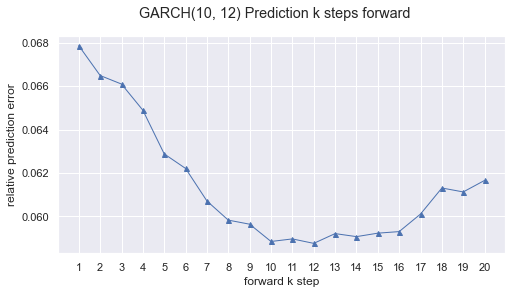

In [36]:
print("GARCH error")
print("GARCH({}, {})  1 step error {:.4f}".format(ar, ma, test_error_garch_all_scenario[0]))
print("GARCH({}, {})  5 step error {:.4f}".format(ar, ma, test_error_garch_all_scenario[4]))
print("GARCH({}, {}) 10 step error {:.4f}".format(ar, ma, test_error_garch_all_scenario[9]))
print("GARCH({}, {}) 15 step error {:.4f}".format(ar, ma, test_error_garch_all_scenario[14]))
print("GARCH({}, {}) 20 step error {:.4f}".format(ar, ma, test_error_garch_all_scenario[19]))

sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_garch_all_scenario)+1))
fig.suptitle("GARCH({}, {}) Prediction k steps forward".format(ar, ma))
plt.xticks(xlabel)
plt.xlabel("forward k step")
plt.ylabel("relative prediction error")
plt.plot([_ for _ in range(1, forward_k+1)], test_error_garch_all_scenario[1:], marker ='^', markersize=5, linewidth=1)
plt.savefig("./output_fig/simulation_results/Stationary_GARCH({},{})_theta{}_alpha1e-2_step1e-2.jpg".format(ar, ma, theta_dim))
fig.show()

GARCH(10, 12)  1 step 95% coverage: 0.1017
GARCH(10, 12)  5 step 95% coverage: 0.4330
GARCH(10, 12) 10 step 95% coverage: 0.7720
GARCH(10, 12) 15 step 95% coverage: 0.8200
GARCH(10, 12) 20 step 95% coverage: 0.8720


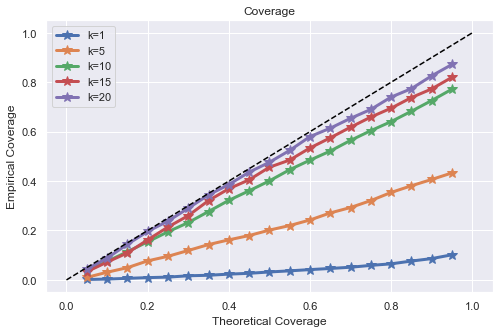

In [37]:
check_points = np.arange(5, 100, 5) / 100
care = [1, 5, 10, 15, 20]

fig = plt.figure(figsize=(8,5))
plt.title("Coverage")
for i in care:
    plt.plot( check_points, coverage_garch_all_scenarios[i] , marker="*", markersize=10,label="k={}".format(i), linewidth = 3)
    print("GARCH({}, {}) {:2} step 95% coverage: {:.4f}".format(ar, ma, i, coverage_garch_all_scenarios[i][-1]))
plt.plot( [0,1], [0,1] , linestyle="--", color="black")
plt.legend()
plt.xlabel("Theoretical Coverage")
plt.ylabel("Empirical Coverage")
plt.savefig("./output_fig/coverage/Stationary_GARCH({},{})_theta{}_alpha1e-2_step1e-2\.jpg".format(ar, ma, theta_dim))


# HARCH

In [38]:
warnings.simplefilter("ignore")
from IPython.utils import io

forward_k = 20
calibration_h = 0.0
ar_h = 20
ma_h = 20

coverage_harch_all_scenarios = None
test_error_harch_all_scenario = None

for scenario_idx in range(n_scenario):
    train_data = train_list[scenario_idx]
    valid_data = valid_list[scenario_idx]
    test_data = test_list[scenario_idx]
    
    returns = []
    index = []
    for day in list(train_data.keys()):
        returns.append(train_data[day]["return"][0])
        index.append(day)
    for day in list(valid_data.keys()):
        returns.append(valid_data[day]["return"][0])
        index.append(day)
    last_val_date = list(valid_data.keys())[-1]
    last_val_date_idx = len(index)-1

    for day in list(test_data.keys()):
        returns.append(test_data[day]["return"][0])
        index.append(day)
    last_test_date = list(test_data.keys())[-1]

    start = 0
    end = last_test_date
    returns = np.array(returns) * math.sqrt(bday_p_year)

    with io.capture_output() as captured:
        am = arch_model(returns, vol='Harch', p=ar_h, o=1, q=ma_h, dist='Normal')
        res = am.fit(last_obs=last_val_date)
        forecasts = res.forecast(horizon=forward_k+1, start=last_val_date_idx-1, method="simulation", simulations=100)

    length_pred = forecasts.variance.count()[0]
    simulation_var = np.array(forecasts.simulations.variances[-length_pred:])
    simulation_quantile = {}
    for i, p in enumerate(simulation_var):
        simulation_quantile[last_val_date_idx-1+i] = cvtLisQuantile(p)
    prediction = forecasts.variance.iloc[last_val_date_idx-1:]
    prediction = prediction.iloc[:-1]
    
    prediction["Date"] = index[last_val_date_idx:]

    test_error_traj_harch = []
    traj_coverage_harch = []
    
    for k in range(1, min(forward_k+1, num_test_day)+1):
        coverage_k_harch = []
        
        column_name = "h.{:02d}".format(k)
        column = prediction[[column_name, "Date"]]
        k_step_test_error_harch = []
        for i, base_date in enumerate(column["Date"].values):
            base_date_idx = index.index(base_date)
            try:
                pred_date = index[base_date_idx+k]
                pred_vol = math.sqrt(column[column_name].iloc[i])
            except IndexError:
                break

            pred_date_p = test_data[pred_date]["price"]
            pred_date_r = test_data[pred_date]["risk ir"]
            pred_date_K = test_data[pred_date]["Strike"]
            pred_date_T = test_data[pred_date]["Exercise Time"]
            pred_date_y = test_data[pred_date]["option price"]
            true_vol = test_data[pred_date]["true vol"]
            
            
            low_end, high_end = simulation_quantile[base_date_idx][k]
            contains_indicator = np.logical_and( low_end+calibration_h < true_vol , true_vol < high_end+calibration_h ) 
            coverage_k_harch.append(contains_indicator)
            pred_price_harch = BSf(pred_vol,
                                   p_t=pred_date_p, 
                                   r_t=pred_date_r, 
                                   K_t=pred_date_K, 
                                   T_t=pred_date_T)

            pred_error_harch = np.average(np.abs(pred_price_harch-pred_date_y) / pred_date_y)
            k_step_test_error_harch.append(pred_error_harch)
            
        traj_coverage_harch.append(np.mean(np.array(coverage_k_harch), axis=0))
        test_error_traj_harch.append( np.average(k_step_test_error_harch ))


    
    test_error_traj_harch = np.expand_dims(np.array(test_error_traj_harch), axis=1)
    traj_coverage_harch = np.expand_dims( np.array(traj_coverage_harch), axis=2 )
    
    if scenario_idx == 0:
        coverage_harch_all_scenarios = np.zeros_like(traj_coverage_harch)
        test_error_harch_all_scenario = np.zeros_like(test_error_traj_harch)
    coverage_harch_all_scenarios = np.concatenate( (coverage_harch_all_scenarios, traj_coverage_harch), axis=2)
    test_error_harch_all_scenario = np.concatenate( (test_error_harch_all_scenario, test_error_traj_harch), axis=1)

coverage_harch_all_scenarios = np.mean(coverage_harch_all_scenarios[:,:,1:], axis=2)
test_error_harch_all_scenario = np.mean(test_error_harch_all_scenario[:,1:], axis=1)


harch error
HARCH(20, 20)  1 step error 0.0459
HARCH(20, 20)  1 step error 0.0459
HARCH(20, 20)  1 step error 0.0464
HARCH(20, 20)  1 step error 0.0474
HARCH(20, 20)  1 step error 0.0475


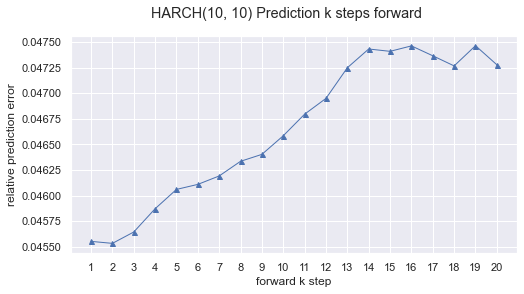

In [39]:
print("harch error")
print("HARCH({}, {})  1 step error {:.4f}".format(ar_h, ma_h, test_error_harch_all_scenario[0]))
print("HARCH({}, {})  1 step error {:.4f}".format(ar_h, ma_h, test_error_harch_all_scenario[4]))
print("HARCH({}, {})  1 step error {:.4f}".format(ar_h, ma_h, test_error_harch_all_scenario[9]))
print("HARCH({}, {})  1 step error {:.4f}".format(ar_h, ma_h, test_error_harch_all_scenario[14]))
print("HARCH({}, {})  1 step error {:.4f}".format(ar_h, ma_h, test_error_harch_all_scenario[19]))



sns.set()
fig = plt.figure(figsize=(8,4))
xlabel = list(range(len(test_error_harch_all_scenario)+1))
fig.suptitle("HARCH(10, 10) Prediction k steps forward")
plt.xticks(xlabel)
plt.xlabel("forward k step")
plt.ylabel("relative prediction error")
plt.plot([_ for _ in range(1, forward_k+1)], test_error_harch_all_scenario[1:], marker ='^', markersize=5, linewidth=1)
plt.savefig("./output_fig/simulation_results/Stationary_HARCH({},{})_theta{}_alpha1e-2_step1e-2.jpg".format(ar_h, ma_h, theta_dim))
fig.show()

HARCH(20, 20)  1 step 95% coverage: 0.2071
HARCH(20, 20)  5 step 95% coverage: 0.3550
HARCH(20, 20) 10 step 95% coverage: 0.4253
HARCH(20, 20) 15 step 95% coverage: 0.4450
HARCH(20, 20) 20 step 95% coverage: 0.4640


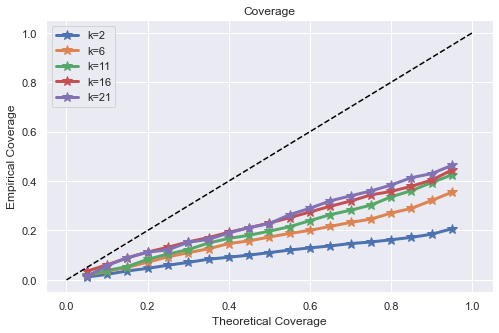

In [40]:
check_points = np.arange(5, 100, 5) / 100
care = [1, 5, 10, 15, 20]

fig = plt.figure(figsize=(8,5))
plt.title("Coverage")
for i in care:
    plt.plot( check_points, coverage_harch_all_scenarios[i] , marker="*", markersize=10,label="k={}".format(i+1), linewidth = 3)
    print("HARCH({}, {}) {:2} step 95% coverage: {:.4f}".format(ar_h, ma_h, i, coverage_harch_all_scenarios[i][-1]))
plt.plot( [0,1], [0,1] , linestyle="--", color="black")
plt.legend()
plt.xlabel("Theoretical Coverage")
plt.ylabel("Empirical Coverage")
plt.savefig("./output_fig/coverage/Stationary_HARCH({},{})_theta{}_alpha1e-2_step1e-2.jpg".format(ar_h, ma_h, theta_dim))
